In [23]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

# Load dataset

In [24]:
train = np.loadtxt("train.txt")
Y = train[:, 0]
X = train[:, 1:] # 1: for all, 1:9 for no wind feature.
print(Y.shape)
print(X.shape)

(3048,)
(3048, 9)


In [25]:
# Define training and test inds
n_train = int(Y.shape[0] * 0.8) # 80 % training
training_inds = np.arange(0, n_train)
testing_inds = np.arange(n_train, len(Y))
n_test = len(testing_inds)

print(n_train)
print(n_test)

2438
610


# Define training and testing data sets

In [26]:
# Train
X_train = X[training_inds, :]
Y_train = Y[training_inds]

# Test
X_test = X[testing_inds, :]

# Train model

In [27]:
%%time
rf_model = RandomForestRegressor(n_jobs=12)
rf_model.fit(X_train, Y_train)

CPU times: user 1.01 s, sys: 92.1 ms, total: 1.1 s
Wall time: 236 ms


RandomForestRegressor(n_jobs=12)

# Save model

In [28]:
# The sklearn model is held internally in the esem model
with open("rf_model.pkl","wb") as f:
    pickle.dump(rf_model, f)

# Inference

In [29]:
%%time
Y_rf_test = rf_model.predict(X_test)

CPU times: user 35.7 ms, sys: 3.86 ms, total: 39.6 ms
Wall time: 103 ms


# Perform analysis

In [30]:
x_1_to_1 = [-9999, 9999]
y_1_to_1 = [-9999, 9999]

In [31]:
def calc_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calc_bias(predictions, targets):
    return (predictions - targets).mean()

Text(0.5, 1.0, 'Slope = 0.9486323198871495\nR^2 = 0.9357258618664055,\np = 0.0,\nRMSE = 1.4067020862359476,\nBias = 0.10966917463545485,\nN = 610,\nX-axis Mean Magnitude = 4.285624884393843')

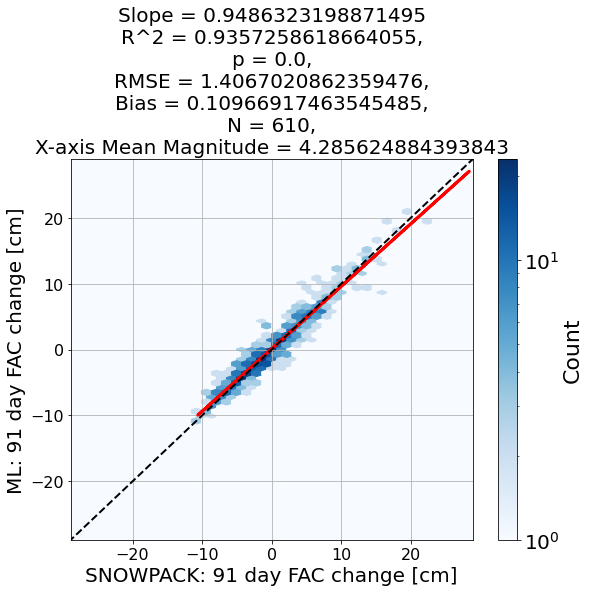

In [32]:
# Random Forest 
x = Y[testing_inds] * 100 # Truth (cm)
y = Y_rf_test * 100 # Prediction (cm)
lin_reg = stats.linregress(x, y)
rmse = calc_rmse(y, x)
bias = calc_bias(y, x)

# Limit
lim = np.max([np.abs(x).max(), np.abs(y).max()])

plt.figure(figsize=(9, 7))
plt.hexbin(x, y, extent=(-lim, lim, -lim, lim), cmap=plt.cm.Blues, bins='log', gridsize=(40, 40))
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])
cb = plt.colorbar()
cb.set_label("Count", fontsize=22)
cb.ax.tick_params(labelsize=20) 
plt.plot(x, lin_reg.intercept + lin_reg.slope*x, 'r', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.grid()
plt.xlabel("SNOWPACK: 91 day FAC change [cm]", fontsize=20)
plt.ylabel("ML: 91 day FAC change [cm]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Slope = " + str(lin_reg.slope) + \
          "\nR^2 = " + str(lin_reg.rvalue**2) + \
          ",\np = " + str(lin_reg.pvalue) + \
          ",\nRMSE = " + str(rmse) + \
          ",\nBias = " + str(bias) + \
          ",\nN = " + str(n_test) + \
          ",\nX-axis Mean Magnitude = " + str(np.abs(x).mean()),
         fontsize=20)

6.8284131447650935


(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

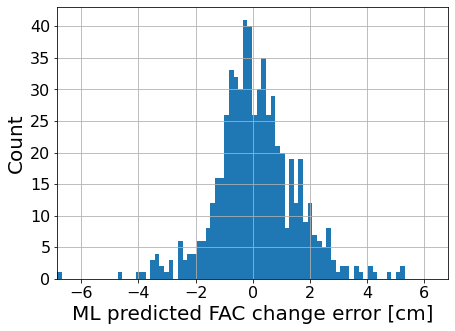

In [33]:
diff = y - x
limit = np.abs(diff).max()
print(limit)

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(diff, bins=75)
plt.grid()
plt.xlim([-limit, limit])
plt.xlabel("ML predicted FAC change error [cm]", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)